# Computer Vision Masterclass: GANs

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/dcgan

In [ ]:
# 생성적 적대 신경망
# 실제로 존재하지 않는 이미지를 만듬.
# 생성자와 구분자로 나뉨.
# 생성자와 구분자 모두 사전정보 없이 원점에서 출발
# 시간이 지남에 따라 두 신경망은 각자의 작업에 특화됨.
# 신경망 구조는 강의 참조

## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.17.1'

## Loading and pre-processing the dataset

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
# 검증셋을 _로 해서 로드 안하는 것처럼 해놨음.
# 이번 강의의 목표는 새로운 이미지 생성. 고로 생성한 이미지와 검증 이미지 비교할 필요 없음.
# 신경망이 학습 이미지만 가지고 자체 이미지 생성법을 학습하는 것.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X_train.shape # 28x28 이미지(0~9)가 총 60000개

(60000, 28, 28)

In [ ]:
28*28 # 총 픽셀 수

784

In [ ]:
y_train.shape

(60000,)

9


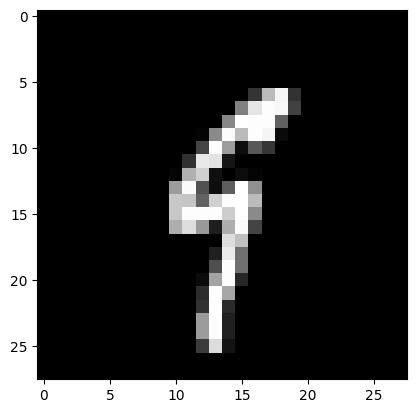

In [ ]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [ ]:
# 텐서플로나 합성곱 신경망을 다룰 때는 채널 차원을 추가해야 함.
# 이 이미지들은 흑백 이미지이므로 1(채널 수)을 끝에 추가해야 함.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [ ]:
# X_train = X_train / 255  # GAN에 관한 논문에서 대부분의 저자가 이걸 사용하면 나쁜 결과를 얻는다고 함.
X_train = (X_train - 127.5) / 127.5   # -1 ~ 1

In [ ]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000 # 60000은 이미지 개수
batch_size = 256 # 각 배치에는 256개의 이미지가 있음. 256개씩 신경망에 보내면서 가중치를 업데이트 함.

In [ ]:
buffer_size / batch_size # 배치 개수는 약 234개

234.375

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
# 넘파이 형식의 데이터를 텐서플로 형식으로 변환 + 미니배치 경사하강법 사용
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
# shuffle -> 데이터를 섞음.

In [ ]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
X_train # None은 이미지 개수를 의미.

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [ ]:
# 생성기 구조 정의
def build_generator():
    network = tf.keras.Sequential()

    network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
    network.add(layers.BatchNormalization()) # 은닉층에서 값을 정규화
    network.add(layers.LeakyReLU()) # relu와 비슷하나 GAN에 더 적합함.
    # 총 7*7*256 = 12544개의 뉴런이 있음. 텐서플로 문서를 참조했음.
    # 더 복잡한 이미지(ex.컬러)로 실행하려면 뉴런과 층을 더 추가해야 할 수도 있음.
    # 생성기의 목적은 임의의 수를 받고 이미지를 생성하는 것이므로 편향 유닛이 필요 없음.
    # 기존 신경망과 다르게 어떤 종류의 예측도 하지 않기 때문.
    # input_shape=(100, ) -> 신경망 입력으로 100개의 임의의 수를 받는다는 의미
    # 이번에는 다른 활성화 함수를 사용하므로 일단 여기서는 활성화함수를 정의하지 않음.


    network.add(layers.Reshape((7,7,256))) # 7*7*256의 값이 벡터 형식.. -> 텐서 형식(like 행렬 형식)으로 바꿔야 함.
    # 합성곱 신경망을 사용하므로 이렇게 형식을 바꿔야 함.

    network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    # Conv2D는 차원을 축소하지만 Conv2DTranspose는 """차원을 증가시킴""".
    # 128은 필터(특징 탐지기) 수. (5,5) -> 필터 크기
    # padding='same'이므로 7x7x128이 됨. 이미지 크기는 줄어들지 않음.

    network.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    # 14x14x64

    network.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # 28x28x1 -> MNIST 이미지 크기와 맞춰줌. 구현자가 난수 이미지와 MNIST 이미지를 받아야 하므로 크기가 같아야 함.
    # 활성화함수로 tanh를 사용. -> 데이터를 정규화할 때, -1~1의 범위를 가지게 했기 때문.
    # 만약 기본적인 정규화로 0~1을 만들었다면 시그모이드를 사용함.

    network.summary()

    return network

In [ ]:
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
# 이 구현된 신경망 구조(생성자)에 난수를 입력으로 넣어야 함.
noise = tf.random.normal([1, 100]) # normal() -> 정규분포를 따르도록 함. 1행 100열. 즉, 100개의 난수를 가진 행렬

In [ ]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.66946346,  1.6359098 , -2.2299545 , -0.10151868,  1.1003851 ,
        -0.75707215, -0.59187835,  0.9669077 ,  0.80894256,  1.2074409 ,
         0.34058726,  0.6203496 ,  0.27390963,  0.7714377 , -0.9386839 ,
        -1.5383294 , -1.3799223 , -0.96376365,  0.7426494 ,  0.22928439,
        -1.1049366 , -0.43393296, -2.0389807 ,  0.45130232,  2.3347542 ,
         1.5484638 ,  0.83821774, -0.85352784, -0.8918975 , -1.2057432 ,
        -0.2120949 ,  2.031183  , -0.26038823, -1.2954636 , -0.4144215 ,
        -0.80507994, -1.1472169 , -1.2083222 ,  0.32937208, -0.4192956 ,
         0.344387  ,  0.23295556, -0.24247336, -0.21237737,  1.631036  ,
        -0.42273164,  0.29730776, -0.48979986,  0.84024113,  0.6538603 ,
         0.5692009 ,  0.2627952 , -0.27722633, -0.07959633,  0.987364  ,
         0.10222253,  1.8482697 , -0.85034424, -0.03583467, -1.6175094 ,
        -1.4233732 , -0.18199329,  0.57549614,  0.5401803 , -0.7225611 ,
 

In [ ]:
generated_image = generator(noise, training=False)
# training=False -> 신경망을 학습시키거나 가중치를 조정하지 않을 것임.
# 이 테스트 작업은 그저 난수를 보내 생성되는 이미지를 얻기 위함.

In [ ]:
generated_image # 생성된 픽셀들을 확인할 수 있음.

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[ 9.08452785e-04],
         [ 2.36695027e-03],
         [ 8.66275746e-03],
         [ 5.34067582e-03],
         [ 5.51649416e-03],
         [ 2.16747355e-03],
         [ 4.38048039e-04],
         [ 5.13212476e-03],
         [ 2.08303495e-03],
         [ 4.05226741e-03],
         [-1.25847047e-03],
         [-6.86825952e-04],
         [-8.10593367e-03],
         [-3.93627165e-03],
         [ 1.06339063e-02],
         [-9.27047431e-03],
         [ 2.96600815e-03],
         [ 1.77948270e-02],
         [ 2.02132342e-03],
         [-4.78376029e-03],
         [-5.32681169e-03],
         [ 2.46374565e-03],
         [ 2.71926844e-03],
         [-2.46648723e-03],
         [ 2.52635172e-03],
         [-6.19301293e-03],
         [-1.03371334e-03],
         [ 9.17521422e-04]],

        [[-3.46084009e-03],
         [ 4.38341592e-03],
         [ 1.81823201e-03],
         [-4.31718398e-03],
         [-1.29326917e-02],
         [ 1.29253

In [ ]:
generated_image.shape # 신경망의 마지막 층과 형태가 같음.

TensorShape([1, 28, 28, 1])

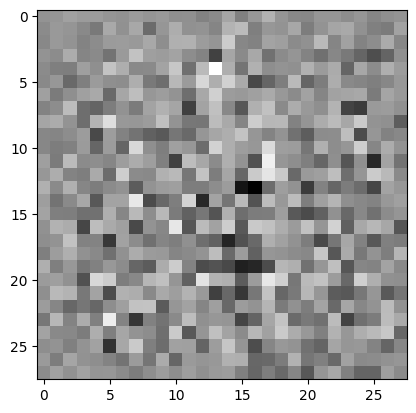

In [ ]:
plt.imshow(generated_image[0, :,:,0], cmap='gray') # 28, 28만 필요함.
# 이 이미지는 무작위 가중치로 생성된 이미지. 신경망이 학습되지 않은 것이므로 이렇게 나옴.

## Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [ ]:
# 구별자 구현
def build_discriminator():
    network = tf.keras.Sequential()

    # 14x14x64 -> Conv2D의 strides=(2,2)때문에 이미지 크기가 반으로 줄어듬.
    network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3)) # 과적합 방지
    # 이 신경망은 입력값으로 MNIST 데이터셋을 받음. # 28,28,1 -> MNIST 이미지 크기

    # 7x7x128
    network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1)) # 이진 분류 문제(ex.가짜 이미지? 진짜 이미지?)이므로 1개의 뉴런만 필요함.
    # 마지막 층에 활성화 함수를 사용하지 않음. 시그모이드를 사용 시 0~1의 값을 가짐.
    # 그러나 이 경우에는 확률을 출력하지 않음.
    # 활성화함수를 선택하지 않으면 확률이 아닌 logit을 출력함.
    # logit은 출력층의 값이 아직 최종 응답에 사용될 준비가 되지 않았음을 의미(like raw data)

    network.summary()

    return network

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator(generated_image, training=False)
# numpy=array([[0.00117164]] -> 이미지에 따라 값이 다름. 이 값을 확률로 바꿀것임.

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.421586e-05]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [ ]:
# 각 신경망의 손실을 계산해야 함.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# 이진분류문제 이므로 BinaryCrossentropy()를 사용.
# logit은 출력층의 값이 아직 최종 응답에 사용될 준비가 되지 않았음을 의미
# from_logits=True -> 텐서플로가 값을 확률이 아닌 logit으로 인식하여
# 이를 이진 교차 엔트로피 함수를 이용하여 확률값으로 변환.
# 신경망의 출력값을 처리하는 또다른 방법임.

In [ ]:
# 구분자의 오차값(손실)을 구하는 함수
def discriminator_loss(expected_output, fake_output): # 실제 이미지와 가짜 이미지를 입력으로 받음.
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # tf.ones_like() -> 1로 구성된 행렬 또는 벡터를 생성. 실제(진짜) 이미지가 클래스 1에 속하기 때문.
    # tf.zeros_like() -> 0로 구성된 행렬 또는 벡터를 생성. 가짜 이미지가 클래스 0에 속하기 때문.
    # 1에 가까울수록 진짜 이미지일 확률이 높고, 0에 가까울수록 가짜 이미지일 확률이 높음.

    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# 구분자의 오차값(손실)을 구하는 함수
def generator_loss(fake_output): # 가짜 이미지를 입력으로 받음.
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    # 가짜 이미지를 1(진짜)과 비교. 구분자 결정 시 생성자가 얼마나 좋은지 측정하기 위함.

# 구분자의 목적은 이 이미지가 진짜인지 확인하는 것.
# 만약 생성자가 잘 동작한다면 구분자는 생성된 이미지를 진짜라고 분류할 것임.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
# GAN으로 작업 시에는 학습률을 작게 하는 것이 좋음.

## Training the model

In [ ]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
epochs = 100
noise_dim = 100 # 생성자의 입력값 형태와 같음. 생성할 무작위 수의 개수
num_images_to_generate = 16 # 16개의 새로운 이미지를 만들어보자

In [ ]:
batch_size, noise_dim

(256, 100)

In [ ]:
@tf.function
# 전역 변수 값을 저장하기 위해 사용. 이 코드를 특정 에포크 횟수만큼 여러번 실행할 것임.
# 따라서 그래이디언트 값이 저장되어야 함.
def train_steps(images): # X_train이 images 매개변수로 들어갈 것임.
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # gen_tape: 생성자의 그래디언트, disc_tape: 구분자의 그래디언트
        # 각각의 변수에 그래디언트 값을 저장할 것임.
        generated_images = generator(noise, training=True) # 가중치를 업데이트해야 함.

        # 진짜, 가짜 이미지 모두 구분자로 보냄.
        expected_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 손실 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)

    # 그래디언트(값의 방향: 가중치를 증가시킬 지, 감소시킬 지) 구하기
    # 목적은 전역 최솟값(오차가 가장 낮은 지점)으로 가는 것.
    # 신경망의 목적은 오차를 줄이는 것.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # generator.trainable_variables -> 우리가 가중치를 업데이트할 신경망의 변수들을 의미
    # summary()에서 나오는 Trainable params 수 만큼의 매개변수(가중치)가 조정됨.

    # 가중치 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # 두 매개변수를 동시에 보내야 하므로 zip()을 사용. -> 2개의 변수를 같은 매개변수로 보낼 수 있음


In [ ]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [ ]:
test_images.shape # 16개의 이미지 각각은 100개의 임의의 값을 가진다는 의미
# 이미지를 생성하기 위해 이 임의의 수를 GAN에 보내는 것이 목표.

TensorShape([16, 100])

In [ ]:
60000 / 256

234.375

In [ ]:
def train(dataset, epochs, test_images):
    for epoch in range(epochs):
        for image_batch in dataset: # 234번 실행됨.
            #print(image_batch.shape)
            train_steps(image_batch) # 그때마다 256개의 이미지 배치를 신경망에 보냄.

        # 각 에포크 후에 생성자가 어떻게 수행되는지 비교
        print('Epoch: ', epoch + 1)
        generated_images = generator(test_images, training=False)
        fig = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.show()

In [ ]:
train(X_train, epochs, test_images)

Output hidden; open in https://colab.research.google.com to view.